# Logistic Regression For Enhancer Activity Prediction
Adam Klie
07/25/2021

In [63]:
# Classics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import pickle

plt.style.use('presentation')
from IPython.display import IFrame

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

In [64]:
import sys
sys.path.append('/cellar/users/aklie/projects/EUGENE/bin/')
import project_utils

# Load data

In [168]:
X, y = np.loadtxt('../data/2021_OLS_Library/block/X_block_0.18-0.4.txt', delimiter=' ', dtype=float), np.loadtxt('../data/2021_OLS_Library/y_binary_0.18-0.4.txt', delimiter=' ', dtype=int)
#X, y = np.loadtxt('../data/2021_OLS_Library/mixed/X_mixed_0.18-0.4.txt', delimiter=' ', dtype=float), np.loadtxt('../data/2021_OLS_Library/y_binary_0.18-0.4.txt', delimiter=' ', dtype=int)
#X, y = np.loadtxt('../data/2021_OLS_Library/mixed_2.0/X_mixed_2.0_0.18-0.4.txt', delimiter=' ', dtype=float), np.loadtxt('../data/2021_OLS_Library/y_binary_0.18-0.4.txt', delimiter=' ', dtype=int)

In [169]:
X.shape, y.shape

((302936, 75), (302936,))

In [170]:
X[0], y[0]

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0.]),
 1)

In [171]:
# Don't remove current feature if more than one unique value
np.unique(X[:,-1], return_counts=True)

(array([0., 1.]), array([272779,  30157]))

In [15]:
# Remove consant feature
#X = X[:,:-1]

# Check logistic regression assumptions

**1. <u> Response variable is binary </u>**

In [16]:
np.unique(y, return_counts=True)

(array([0, 1]), array([208729,  94207]))

Check

**2. <u> Observations are independent </u>**

Check. These are all independent observations

**3. <u> No multicolinearity between features </u>**

In [73]:
#project_utils.multicollinearity_assumption(X)

**4. <u> There are No Extreme Outliers </u>**

This is something I would have to think about more but I think the preprocessing steps probably got rid of a lot of these

**5. <u> There is a Linear Relationship Between Explanatory Variables and the Logit of the Response Variable </u>**

Can maybe use this box tidwell test for each variable?

**6. <u> Large enough sample size </u>**

General rule of thumb here is to have 10 examples for the least frequent outcome for each predictor variable you have

In [17]:
y_counts = np.unique(y, return_counts=True)[1]
p = y_counts[1]/len(y)
print("(10*{})/({}) = {}".format(X.shape[1], p, (10*X.shape[1])/p))

(10*75)/(0.310979876937703) = 2411.731612300572


# Train and test a logistic regression model

## **Train/test split**

In [177]:
from sklearn.model_selection import train_test_split

In [178]:
split = 0.9

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split, random_state=13, shuffle=True)

In [180]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((272642, 75), (30294, 75), (272642,), (30294,))

In [181]:
np.unique(y_train, return_counts=True)[1]/len(y_train), np.unique(y_test, return_counts=True)[1]/len(y_test)

(array([0.68878236, 0.31121764]), array([0.69115997, 0.30884003]))

## **Standardize features:** *For mixed encoding only*

In [124]:
#scale_indeces = np.array([0, 3, 4, 7, 8, 11, 12, 15, 16, 19, 20])  # Mixed 1.0
scale_indeces = np.array([0, 5, 10, 15, 20, 25])  # Mixed 2.0

In [125]:
means = X_train[:, scale_indeces].mean(axis=0)
stds = X_train[:, scale_indeces].std(axis=0)

In [126]:
X_train[:, scale_indeces] -= means
X_train[:, scale_indeces] /= stds

In [127]:
X_train[:, scale_indeces].mean(axis=0), X_train[:, scale_indeces].std(axis=0)

(array([-3.72156537e-17, -8.61328681e-17,  6.50101178e-17,  5.79083912e-17,
         3.13779041e-17,  1.27648650e-16]),
 array([1., 1., 1., 1., 1., 1.]))

In [128]:
X_test[:, scale_indeces] -= means
X_test[:, scale_indeces] /= stds

## **Logistic Regression training**

In [129]:
from sklearn.linear_model import LogisticRegression

In [130]:
clf = LogisticRegression(random_state=13, verbose=1)  #, class_weight='balanced') #{0:1, 1:2})

In [131]:
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished


LogisticRegression(random_state=13, verbose=1)

In [132]:
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 13,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 1,
 'warm_start': False}

#### <u> **Load previously trained model** </u>

In [182]:
from sklearn.linear_model import LogisticRegression
import pickle

file = '0.18-0.4_block_LR-clf.pickle'
clf = pickle.load(open(file, 'rb'))

## **Logistic regression testing**

In [183]:
prob_thresh = 0.5

In [184]:
y_tr_probs = clf.predict_proba(X_train)[:, 1]
y_probs = clf.predict_proba(X_test)[:, 1]

In [185]:
y_tr_preds = (y_tr_probs >= prob_thresh).astype(int)
y_preds = (y_probs >= prob_thresh).astype(int)

In [186]:
if prob_thresh == 0.5:
    if (y_tr_preds == clf.predict(X_train)).all() and (y_preds == clf.predict(X_test)).all():
        print("Predictions looks good")
    else:
        print("No cigar")
else:
    if not ((y_tr_preds == clf.predict(X_train)).all() and (y_preds == clf.predict(X_test)).all()):
        print("Using different threshold ({}), expect preds to be different and they are".format(prob_thresh))
    else:
        print("These shouldn't be the same...")

Predictions looks good


### <u>**Confusion matrices** </u>

In [187]:
from sklearn.metrics import confusion_matrix

In [188]:
np.unique(y_tr_preds, return_counts=True), np.unique(y_preds, return_counts=True)

((array([0, 1]), array([249868,  22774])),
 (array([0, 1]), array([27738,  2556])))

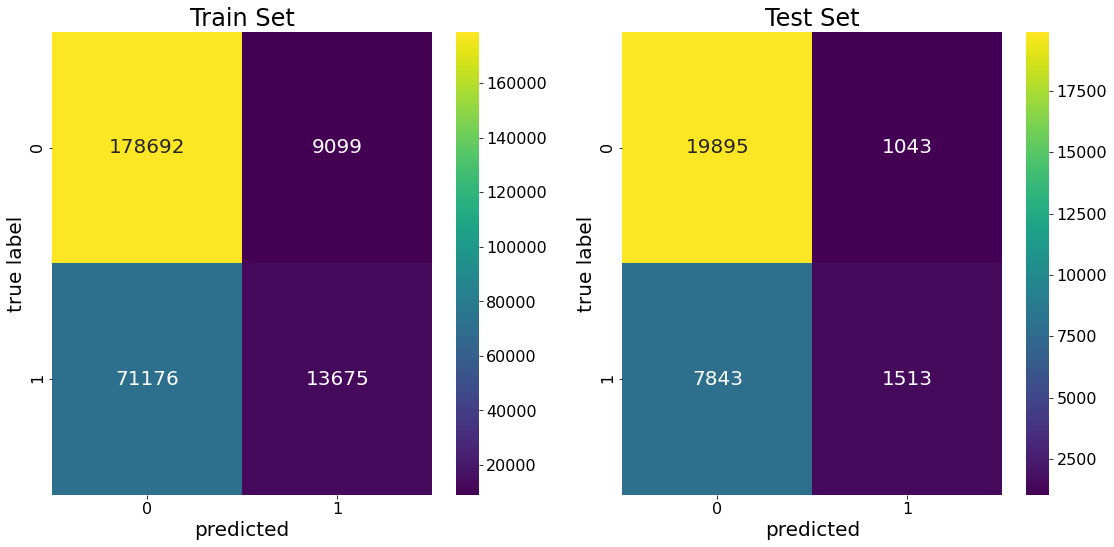

In [189]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
rc = {"font.size" : 20}
with plt.rc_context(rc):
    sns.heatmap(confusion_matrix(y_train, y_tr_preds), annot=True, fmt='d', cmap='viridis', ax=ax[0])
    ax[0].set_xlabel('predicted')
    ax[0].set_ylabel('true label')
    ax[0].set_title('Train Set')

    sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='d', cmap='viridis', ax=ax[1])
    ax[1].set_xlabel('predicted')
    ax[1].set_ylabel('true label')
    ax[1].set_title('Test Set')

    fig.tight_layout();

### <u> **Accuracies** </u>

In [190]:
from sklearn.metrics import accuracy_score

In [191]:
train_acc, test_acc = accuracy_score(y_true=y_train, y_pred=y_tr_preds), accuracy_score(y_true=y_test, y_pred=y_preds)

In [192]:
print("Threshold", "Train Acc", "Test Acc", sep='\t')
print("{:.1f}\t{:.4f}\t{:.4f}".format(prob_thresh, train_acc, test_acc))

Threshold	Train Acc	Test Acc
0.5	0.7056	0.7067


### <u> **F-scores** </u>

In [193]:
IFrame('https://en.wikipedia.org/wiki/F-score', width=800, height=400)

In [194]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [195]:
def fbeta_score(pr, rec, beta):
    return (1+(beta**2))*((pr*rec)/(((beta**2)*pr)+rec))

In [196]:
train_prec, test_prec = precision_score(y_true=y_train, y_pred=y_tr_preds), precision_score(y_true=y_test, y_pred=y_preds)

In [197]:
train_recall, test_recall = recall_score(y_true=y_train, y_pred=y_tr_preds), recall_score(y_true=y_test, y_pred=y_preds)

In [198]:
train_f1, test_f1 = f1_score(y_true=y_train, y_pred=y_tr_preds), f1_score(y_true=y_test, y_pred=y_preds)

In [199]:
fbeta_tr_scores = []
fbeta_scores = []
for b in [0.1, 0.5, 1, 2, 10]:
    fbeta_tr_scores.append(fbeta_score(train_prec, train_recall, b))
    fbeta_scores.append(fbeta_score(test_prec, test_recall, b))

In [200]:
print("Metric", "Threshold", "Train", "Test", sep='\t')
print("{:s}\t{:.1f}\t{:.4f}\t{:.4f}".format("Precision", prob_thresh, train_prec, test_prec))
print("{:s}\t{:.1f}\t{:.4f}\t{:.4f}".format("Recall", prob_thresh, train_recall, test_recall))
#print("{:s}\t{:.1f}\t{:.4f}\t{:.4f}".format("F1-Score", prob_thresh, train_f1, test_f1))
for i, b in enumerate([0.1, 0.5, 1, 2, 10]):
    print("F{:s}-Score\t{:.1f}\t{:.4f}\t{:.4f}".format(str(b), prob_thresh, fbeta_tr_scores[i], fbeta_scores[i])) 

Metric	Threshold	Train	Test
Precision	0.5	0.6005	0.5919
Recall	0.5	0.1612	0.1617
F0.1-Score	0.5	0.5847	0.5767
F0.5-Score	0.5	0.3886	0.3864
F1-Score	0.5	0.2541	0.2540
F2-Score	0.5	0.1888	0.1892
F10-Score	0.5	0.1623	0.1629


### <u> **Precision-recall** </u>

In [201]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [202]:
precs_tr, recs_tr, threshs_tr = precision_recall_curve(y_true=y_train, probas_pred=y_tr_probs)
avg_prec_tr = average_precision_score(y_true=y_train, y_score=y_tr_probs)

In [203]:
precs, recs, threshs = precision_recall_curve(y_true=y_test, probas_pred=y_probs)
avg_prec = average_precision_score(y_true=y_test, y_score=y_probs)

In [204]:
avg_prec_tr, avg_prec

(0.4731631217532038, 0.46916371509076704)

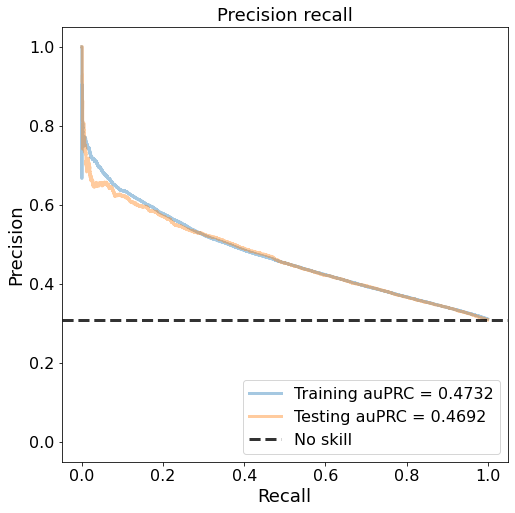

In [205]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.step(recs_tr, precs_tr, where='post', lw=3, alpha=0.4, label='Training auPRC = %0.4f' % (avg_prec_tr))
ax.step(recs, precs, where='post', lw=3, alpha=0.4, label='Testing auPRC = %0.4f' % (avg_prec))
ax.axhline(len(y_test[y_test==1])/len(y_test), linestyle='--', lw=3, color='k', label='No skill', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('Recall', fontsize=18)
ax.set_ylabel('Precision', fontsize=18)
ax.set_title('Precision recall', fontsize=18)
ax.legend(loc="lower right", fontsize=16);

### <u> **Reciever operating characteristic** </u>

In [206]:
from sklearn.metrics import roc_curve, auc

In [207]:
fprs_tr, tprs_tr, threshs_tr = roc_curve(y_true=y_train, y_score=y_tr_probs)
roc_auc_tr = auc(fprs_tr, tprs_tr)

In [208]:
fprs, tprs, threshs = roc_curve(y_true=y_test, y_score=y_probs)
roc_auc = auc(fprs, tprs)

In [209]:
roc_auc_tr, roc_auc

(0.6575669482413836, 0.6604374390058787)

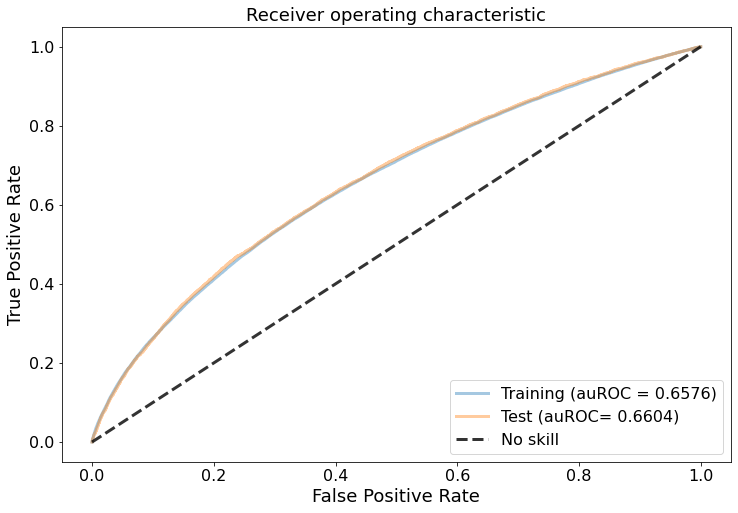

In [210]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(fprs_tr, tprs_tr, lw=3, alpha=0.4, label='Training (auROC = %0.4f)' % (roc_auc_tr))
ax.plot(fprs, tprs, lw=3, alpha=0.4, label='Test (auROC= %0.4f)' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='k', label='No skill', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_title('Receiver operating characteristic', fontsize=18)
ax.legend(loc="lower right", fontsize=16);

## Save the classifier

In [161]:
import pickle

In [162]:
#file = '0.18-0.4_block_LR-clf.pickle'
#file = '0.18-0.4_mixed_LR-clf.pickle'
file = '0.18-0.4_mixed_2.0_LR-clf.pickle'

In [163]:
pickle.dump(clf, open(file, 'wb'))

In [62]:
test_load = pickle.load(open(file, 'rb'))
np.unique(test_load.predict(X_test), return_counts=True)

(array([0, 1]), array([27738,  2556]))